In [1]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

SEED = 1337
random.seed(SEED)

INFO 02-18 16:07:11 __init__.py:190] Automatically detected platform cuda.


In [2]:
df = pd.read_csv("../../data/data_raw/nyt-articles-2020.csv")
df.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [3]:
df.isna().sum()

newsdesk          0
section           0
subsection    11094
material          0
headline          0
abstract          3
keywords          1
word_count        0
pub_date          0
n_comments        0
uniqueID          0
dtype: int64

In [4]:
df.dropna(subset=["abstract"], inplace=True)

In [5]:
df["length_abstract"] = df["abstract"].str.len()
df["length_headline"] = df["headline"].str.len()
df

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID,length_abstract,length_headline
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,114,27
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,53,22
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...,120,53
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...,123,40
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...,129,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16782,Editorial,Opinion,NaN,Op-Ed,What It Takes to Heal From Covid-19,"Survivors can get better, but they need help.","['Chronic Condition (Health)', 'Coronavirus (2...",1002,2020-12-31 15:27:47+00:00,166,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...,45,35
16783,Sports,Sports,Baseball,News,Padres Jolt M.L.B. With Bold Moves to Set Up W...,While many teams continued to assess the finan...,"['San Diego Padres', 'Major League Baseball', ...",1100,2020-12-31 15:47:44+00:00,42,nyt://article/1f11417d-2c57-51b9-b75d-8f67f0a9...,198,61
16784,Business,Business Day,NaN,News,"Their Finances Ravaged, Customers Fear Banks W...",Banks have the power to decide whether to let ...,"['Banking and Financial Institutions', 'Corona...",1429,2020-12-31 16:21:40+00:00,556,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...,178,74
16785,Dining,Food,"Wine, Beer & Cocktails",News,Should Wine Be Among Your Health Resolutions?,The new category of ‘clean wines’ is an effort...,"['Wines', 'Grapes', 'Diet and Nutrition', 'Dia...",1307,2020-12-31 17:28:11+00:00,277,nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...,139,45


In [6]:
df.sort_values("length_abstract", ascending=False).tail(10)

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID,length_abstract,length_headline
6060,OpEd,Opinion,NaN,Op-Ed,There May Be a Dangerous Shortcut to a Coronav...,Should we take it?,"['Coronavirus (2019-nCoV)', 'Viruses', 'Smallp...",1457,2020-04-30 21:45:03+00:00,148,nyt://article/95e2ce8d-ca30-5194-ae73-f63c1855...,18,58
7800,OpEd,Opinion,NaN,Op-Ed,Stacey Abrams: I Know Voting Feels Inadequate ...,Just hear me out.,"['Voting and Voters', 'Elections', 'George Flo...",1603,2020-06-04 13:45:23+00:00,1151,nyt://article/69aa2471-e35c-5004-bd9f-aac7aafb...,17,55
755,Styles,Style,NaN,News,Dog the Bounty Hunter Is Hunting Alone,Life after Beth.,"['Bounty Hunters', 'Fugitives', 'Chapman, Beth...",1978,2020-01-17 10:00:12+00:00,295,nyt://article/04b2ee61-ffa5-5ddc-b396-8698dd33...,16,38
390,OpEd,Opinion,Sunday Review,Op-Ed,Black Britons Know Why Meghan Markle Wants Out,It’s the racism.,"['Royal Families', 'Markle, Meghan', 'Harry, D...",990,2020-01-09 20:11:35+00:00,1877,nyt://article/70c1bd73-8d85-5d46-b14f-592b8704...,16,46
1476,OpEd,Opinion,NaN,Op-Ed,The Simple Reason Trump Does What He Does,Because he can.,['Trump-Ukraine Whistle-blower Complaint and I...,929,2020-02-03 00:54:52+00:00,2427,nyt://article/0fff00a8-2c3d-5569-a545-b9fae83f...,15,41
11780,OpEd,Opinion,NaN,Op-Ed,Who Can Win America’s Politics of Humiliation?,Trump or Biden?,"['Presidential Election of 2020', 'Democratic ...",1293,2020-09-08 22:30:39+00:00,1677,nyt://article/b50478ea-ca81-5729-9be9-6d083426...,15,46
11171,OpEd,Opinion,NaN,Op-Ed,Jerry Seinfeld: So You Think New York Is ‘Dead’,(It’s not.),"['Comedy and Humor', 'New York City', 'Coronav...",666,2020-08-24 09:00:15+00:00,2742,nyt://article/c7e958f0-d1f0-5288-beb2-4a6599a1...,11,47
3303,Magazine,Magazine,NaN,Interactive Feature,Brittany Howard Gets Her Revenge,In a song.,"['Music', 'Discrimination', 'Alabama Shakes (M...",0,2020-03-12 03:33:46+00:00,7,nyt://interactive/3437a298-2b80-57ec-b256-a2f7...,10,32
5593,Summary,Style,NaN,News,Wait … Is Twitter Good Now?,Sort of.,"['Social Media', 'Computers and the Internet',...",757,2020-04-22 15:52:16+00:00,10,nyt://article/b515c121-03b7-5a9b-b207-2076d659...,8,27
3665,OpEd,Opinion,NaN,Op-Ed,Should I Still Be Going Out?,No.,"['Coronavirus (2019-nCoV)', 'Celebrities', 'Ce...",104,2020-03-18 15:25:27+00:00,534,nyt://article/ac143d55-5840-5b65-a718-b931fccf...,3,28


<Axes: >

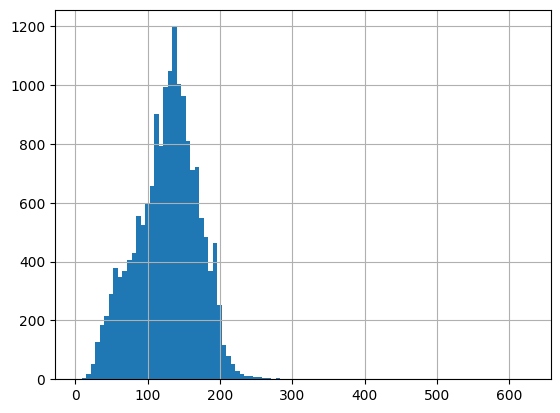

In [7]:
df["length_abstract"].hist(bins=100)

In [8]:
df = df[(df["length_abstract"] >= 50) & (df["length_headline"] >= 10)]

In [10]:
df.duplicated(subset="abstract").sum()

np.int64(196)

In [13]:
df.drop_duplicates(subset="abstract", inplace=True)

/tmp/ipykernel_1887/3093063968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset="abstract", inplace=True)


In [9]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [10]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for writing article abstracts. Based on provided headline and a list of keywords generate abstract of an article. MAKE SURE TO REPLAY ONLY WITH THE ABSTRACT."},
                {"role": "user", "content": "Headline: \n {headline} \n  Keywords: \n {keywords}."},
                {"role": "assistant", "content": "Abstract: \n"}]

In [11]:
prompts = []
for headline, keywords in df[["headline", "keywords"]].values:
    try:
        kw = ", ".join(eval(keywords))
    except:
        kw = "None"
    prompt = [
        BASE_PROMPT[0], # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(headline=headline, keywords=kw)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    prompts.append(prompt)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [13]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

126it [00:03, 34.24it/s]                         


In [14]:
too_large = [i for i, l in enumerate(lens) if l > 32_768]
too_large

[]

In [15]:
df.drop(columns=["newsdesk", "section", "subsection", "material", "headline", "keywords", "word_count", "pub_date", "n_comments", "uniqueID", "length_abstract", "length_headline"], inplace=True)
df.to_csv("../../data/data_human/nyt_articles.csv", index=False)

/tmp/ipykernel_6168/2201411992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["newsdesk", "section", "subsection", "material", "headline", "keywords", "word_count", "pub_date", "n_comments", "uniqueID", "length_abstract", "length_headline"], inplace=True)


In [35]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=40_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=40_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=40_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=40_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=40_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=40_000, seed=SEED),  # Highly Creative
]

In [36]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/nyt_articles/nyt-articles_"

In [37]:
for llm in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 00:34:28 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 00:34:39 config.py:542] This model supports multiple tasks: {'generate', 'classify', 'score', 'embed', 'reward'}. Defaulting to 'generate'.
INFO 02-15 00:34:39 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 00:34:50 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 00:34:52 worker.py:267] Memory profiling takes 2.16 seconds
INFO 02-15 00:34:52 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 00:34:52 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 00:34:52 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 00:34:52 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 00:34:58 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:25<00:00,  1.37it/s]

INFO 02-15 00:35:23 model_runner.py:1562] Graph capturing finished in 26 secs, took 0.12 GiB
INFO 02-15 00:35:23 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 33.89 seconds



  0%|          | 0/2098 [00:00<?, ?it/s]

INFO 02-15 00:35:24 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/2098 [00:13<3:54:58,  6.73s/it]


In [ ]:
df = pd.read_csv("../../data/data_ai/nyt_articles/nyt-articles_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",The increasing trend of for-profit schools lur...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...",Unraveling the Fascination with Crossword Puzz...,1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...","In 2020, a spectacular meteor shower swept acr...",1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",As the universe continues to fascinate us with...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...","In 2020, a pivotal year for space exploration,...",1.2,0.7,20
